<a href="https://colab.research.google.com/github/dainfinity/PyEx2/blob/master/HarmonicVibrator/HV_t10_self.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ライブラリをインストール

In [ ]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker

import numpy as np
import time
import scipy.io
from IPython.display import clear_output

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 
torch.set_default_tensor_type('torch.cuda.FloatTensor')

cuda


# モデル構築

In [ ]:
class PINNsModel(nn.Module):

  def __init__(self):
    super().__init__()

    # 層を定義
    self.fc1_20 = nn.Linear(1,20)
    self.fc20_20 = nn.Linear(20,20)
    self.fc20_1 = nn.Linear(20,1)
    self.tanh = nn.Tanh()

    # 損失関数を定義
    self.loss_function = nn.MSELoss(reduction ='mean')

    # 重みを初期化
    nn.init.xavier_normal_(self.fc1_20.weight.data, gain=1.0)
    nn.init.xavier_normal_(self.fc20_20.weight.data, gain=1.0)
    nn.init.xavier_normal_(self.fc20_1.weight.data, gain=1.0)

    # バイアスを初期化
    nn.init.zeros_(self.fc1_20.bias.data)
    nn.init.zeros_(self.fc20_20.bias.data)
    nn.init.zeros_(self.fc20_1.bias.data)

  def forward(self,X):
    if torch.is_tensor(X) != True:         
        X = torch.from_numpy(X).float().to(device).clone()
      
    #入力の前処理
    X_s = (X - lb_tf)/(ub_tf - lb_tf)  #正規化

    #float型に変換
    X_s = X_s.float()

    # 順伝播
    out = self.fc1_20(X_s)

    for i in range(7):
      out = self.tanh(out)
      out = self.fc20_20(out)
    
    out = self.fc20_1(out)

    return out


  def loss(self, X0, x0_exa, v0_exa, X_to_train_f):

    # 引数の説明
    # X0:t=0での入力(t=0)
    # x0_exa:初期値x(0)の教師データ
    # v0_exa: 初速度v(0)の教師データ
    # X_to_train_f: 入力t

    # t=0での微分を計算
    h = X0.clone()

    h.requires_grad = True

    x0 = self.forward(h)

    x0_t = autograd.grad(x0,h,torch.ones([X0.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]

    # t=0以外での微分を計算
    g = X_to_train_f.clone()
                        
    g.requires_grad = True
        
    x = self.forward(g)

    x_t = autograd.grad(x,g,torch.ones([X_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]

    x_tt = autograd.grad(x_t,g,torch.ones(X_to_train_f.shape).to(device), create_graph=True)[0]

    f = x_tt + omega ** 2 * x     # 1次元調和振動子の微分方程式の左辺を計算(すべて左辺に持ってきたと仮定)

    # 初速度についてのloss
    loss_v0 = self.loss_function(x0_t, v0_exa)

    # 初期位置に対するloss
    loss_x0 = self.loss_function(self.forward(X0), x0_exa)

    # 微分方程式についてのloss
    loss_f = self.loss_function(f,f0_tf)

    # lossの合計
    loss = loss_v0 + loss_x0 + loss_f

    return loss


  def test(self):

    x_pred = self.forward(X_sol) #X_sol:解析解
    
    error_vec = torch.linalg.norm((x_sol-x_pred),2)/torch.linalg.norm(x_sol,2)
    
    x_pred = x_pred.cpu().detach().numpy()

    test_error = error_vec.cpu().detach().numpy()

    return error_vec, x_pred, test_error

# 入出力の変数を作成

In [ ]:
N = 10000
t_f = [0, 10]

# 入出力変数を作成
t0 = np.zeros([N, 1])
t0_tf = torch.from_numpy(t0).clone().float().to(device)
x0 = np.zeros([N, 1])
x0_tf = torch.from_numpy(x0).clone().float().to(device)

t_f_min = t_f[0]
t_f_len = t_f[1] - t_f[0]

t_f = t_f_len * np.random.rand(N, 1) + t_f_min

X = t_f
X0 = t0

lb = X.min()
ub = X.max()

# テンソルに変換
X_tf = torch.from_numpy(X).clone().float().to(device).clone()
X0_tf = torch.from_numpy(X0).clone().float().to(device).clone()

# 微分方程式に関する損失を計算するために必要な0テンソル
f0_tf = torch.zeros(X_tf.shape[0],1).to(device)
v0_x_tf = torch.zeros(X_tf.shape[0],1).to(device) + 5.0

lb_tf = lb + torch.zeros(X_tf.shape[0],1).to(device)
ub_tf = ub + torch.zeros(X_tf.shape[0],1).to(device)

# testデータを作成

In [ ]:
gra = 9.8
omega = 3.0
z0 = 0
v0_sol = 5.0
t_sol = np.linspace(0,10,N)
t_sol = t_sol.reshape(N,1)
# testの入力
X_sol = torch.from_numpy(t_sol).clone().float().to(device).clone()
X_sol = X_sol
# testの出力
x_sol = v0_sol / omega * torch.sin(omega * X_sol)

# 学習・推論

In [ ]:
PINN = PINNsModel()
       
PINN.to(device)

print(PINN)

params = list(PINN.parameters())

'Adam Optimizer'
optimizer = optim.Adam(PINN.parameters(), lr=0.001,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

max_iter = 80000

start_time = time.time()

error_list = []

for i in range(max_iter):

    loss = PINN.loss(X0_tf, x0_tf, v0_x_tf, X_tf)
           
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    
    loss.backward() #backprop

    optimizer.step()

    error_vec, _, test_error = PINN.test()

    error_list.append(test_error)
    
    if i % (max_iter/10) == 0:

        print(loss,error_vec)
    
    
elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

PINNsModel(
  (fc1_20): Linear(in_features=1, out_features=20, bias=True)
  (fc20_20): Linear(in_features=20, out_features=20, bias=True)
  (fc20_1): Linear(in_features=20, out_features=1, bias=True)
  (tanh): Tanh()
  (loss_function): MSELoss()
)
tensor(26.7181, grad_fn=<AddBackward0>) tensor(1.0019, grad_fn=<DivBackward0>)
tensor(0.7551, grad_fn=<AddBackward0>) tensor(0.7653, grad_fn=<DivBackward0>)
tensor(0.6452, grad_fn=<AddBackward0>) tensor(0.7201, grad_fn=<DivBackward0>)
tensor(0.6173, grad_fn=<AddBackward0>) tensor(0.6967, grad_fn=<DivBackward0>)
tensor(0.5596, grad_fn=<AddBackward0>) tensor(0.6661, grad_fn=<DivBackward0>)
tensor(0.5235, grad_fn=<AddBackward0>) tensor(0.6361, grad_fn=<DivBackward0>)
tensor(0.5048, grad_fn=<AddBackward0>) tensor(0.6190, grad_fn=<DivBackward0>)
tensor(0.4605, grad_fn=<AddBackward0>) tensor(0.5728, grad_fn=<DivBackward0>)
tensor(0.0033, grad_fn=<AddBackward0>) tensor(0.0238, grad_fn=<DivBackward0>)
tensor(0.0080, grad_fn=<AddBackward0>) tensor(0.0

# testのerrorを描画

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

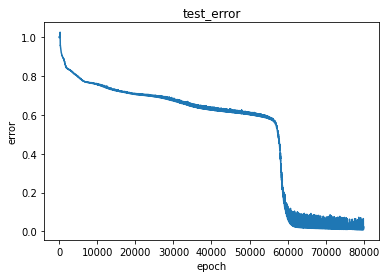

In [ ]:
plt.plot(error_list)

plt.xlabel("epoch")
plt.ylabel("error")
plt.title("test_error")

plt.plot

# 予測値と解析解を比較

In [ ]:
# グラフ描画に日本語を適応するための設定
!pip install japanize_matplotlib
import japanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.1 MB 5.0 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=81be347b686d3fa276215cf5912182b0fc3c8a408a149dcd88722aebd063db48
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


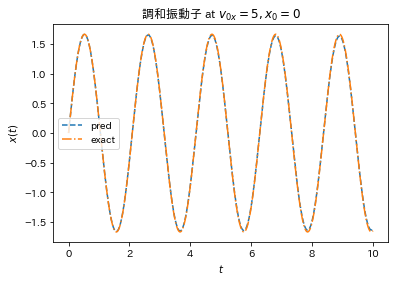

In [ ]:
_, x_pred, _ = PINN.test()

plt.plot(t_sol, x_pred, label = "pred", linestyle = "dashed")
plt.plot(t_sol, v0_sol / omega * np.sin(omega * t_sol), label = "exact", linestyle = "dashdot")
plt.xlabel("$t$")
plt.ylabel("$x(t)$")
plt.title("調和振動子 at $v_{0x}=5, x_0=0$")
plt.legend()
# plt.savefig("//content//drive//MyDrive//PhyEx2//HarmonicVibrator//HarmonicVibratorAtN10000.png")
plt.show()